Purpose of this notebook: 
* reads and summarizes the outputs from projections and smoothing
* creates LaTeX table for the paper 
* creates fig. 6 


In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%autoreload 2
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = (10, 8)
import pprint

In [3]:
from __future__ import (print_function, division)
import pandas as pd
import h5py
import sys
from astropy.stats import (biweight_location, biweight_midvariance)
import scipy

/Users/karenyng/Documents/illustris_analyses/code/IlEnv/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


homebrew modules

In [4]:
sys.path.append("../")
import extract_catalog as ec
import get_DM_centroids as getDM
# import seaborn as sns
import compute_distance as compDist
import plot_cred_int as plotCI
import get_KDE
import compute_clst_prop as compClst
from collections import OrderedDict

In [5]:
data_path = "../../data/test_results/"

# read in files 

In [6]:
total_clstNo = 43
date_stamp = '06_17_16'

DM_fhats = \
    h5py.File(data_path +
              "DM_fhat_clst{0}_{1}.h5".format(
            total_clstNo, date_stamp), 'r')
star_fhats = \
    h5py.File(data_path +
              "stars_fhat_clst{0}_{1}.h5".format(
            total_clstNo, date_stamp), 'r')

In [7]:
main_FOF_h5 = h5py.File(
        "../../data/" +
        "Illustris-1_fof_subhalo_myCompleteHaloCatalog_00135" +
        ".hdf5", "r")

In [8]:
rich_clst = sorted([int(no) for no in star_fhats.keys()])

In [9]:
mass_keys = [ 
    u'Group_M_Crit200',
    u'Group_M_Crit500',
    u'GroupMass'
]

In [10]:
# do cbind of 3 dfs 
masses_df = pd.concat([pd.DataFrame(
            main_FOF_h5['Group'][key][rich_clst],
            columns=[key], index=rich_clst) for key in mass_keys],
            axis=1)                        

In [11]:
%time clst_dfs = map(lambda x: ec.extract_clst(main_FOF_h5, x), rich_clst)

clstNo_mapping = {clstNo: i for i, clstNo in enumerate(rich_clst)}

CPU times: user 708 ms, sys: 19.4 s, total: 20.1 s
Wall time: 22 s


# projection dependent part

In [12]:
uber_df = pd.read_hdf("../../data/uber_df_{}.h5".format(date_stamp), "df")
dom_peak_gpby = uber_df.groupby(['peak_id', 'bin_width'])
dom_peak_df_25 = dom_peak_gpby.get_group((0, 25.0))
dom_peak_df_25['clstNo'] = dom_peak_df_25.index

/Users/karenyng/Documents/illustris_analyses/code/IlEnv/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# projection independent part 

In [28]:
# fraction of subfind halo mass / amount of substructures 
relaxedness0= np.array(
    [compClst.compute_relaxedness0(
     clst_dfs[clstNo_mapping[clstNo]], main_FOF_h5, clstNo) 
     for clstNo in rich_clst])

# eccentricity / asymmetry
relaxedness1= np.array(
    [compClst.compute_relaxedness1(
     clst_dfs[clstNo_mapping[clstNo]], main_FOF_h5, clstNo) 
     for clstNo in rich_clst])

clst_prop_df = compDist.construct_uber_result_df(
    star_fhats, DM_fhats, main_FOF_h5
)

In [29]:
clst_prop_df.index = masses_df.index
mega_clst_prop_df = pd.concat([clst_prop_df, masses_df], axis=1)

mega_clst_prop_df['relaxedness0'] = relaxedness0
mega_clst_prop_df['relaxedness1'] = relaxedness1

del mega_clst_prop_df['M200C']

# Gather the different physical properties

In [30]:
def str_formatter(var):
    return '{0:.2f}'.format(var)

gather a bunch of properties for computing the correlation 

* median(total peak density)
* median(KDE)
* max(total_peak_dens)
* max(KDE)
* richness 
* group_M_Crit200
* group_M_Crit500
* groupMass
* relaxedness0
* relaxedness1 

# plot the projection uncertainty of $\Delta y_{\rm KDE}$ by cluster

In [31]:
dom_peak_clst_gpby = dom_peak_df_25.groupby('clstNo')
rich_clst_nos = np.unique(dom_peak_df_25.index)
clst_dom_KDE_stat = [dom_peak_clst_gpby.get_group(clstNo)['Delta_y_KDE']
                     for clstNo in clstNo_mapping]
clst_total_peak_dens_stat = [
    dom_peak_clst_gpby.get_group(clstNo)['total_peaks_dens']
    for clstNo in rich_clst_nos]

In [32]:
for tempdf in clst_dom_KDE_stat:
    tempdf.index = range(tempdf.shape[0])
df = pd.concat(clst_dom_KDE_stat, axis=1)
df.columns = rich_clst_nos

# See the actual distributions of $\Delta y_{\rm KDE}$

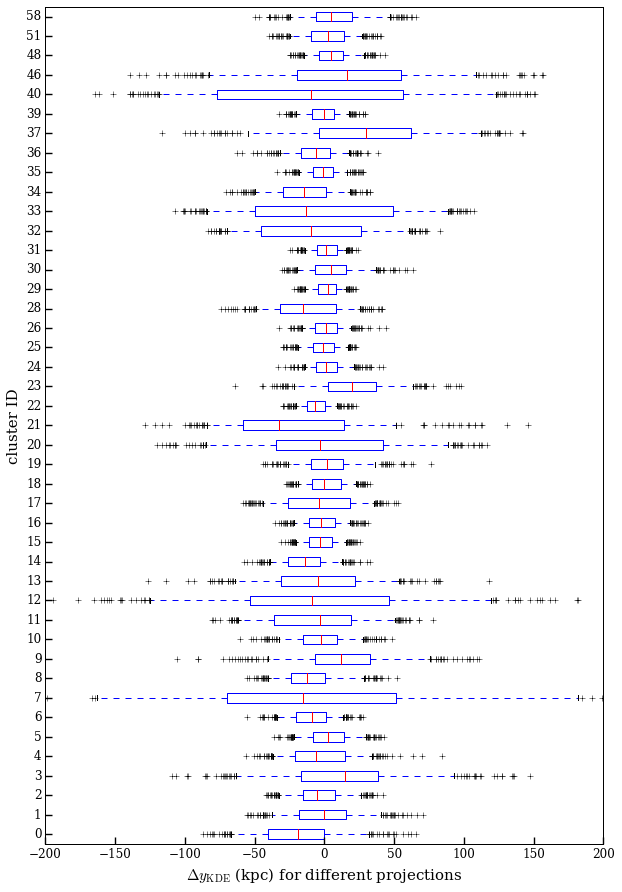

In [34]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111)
KDE_proj_uncertainty_dict  = plt.boxplot(
    clst_dom_KDE_stat, vert=0, whis=[5, 95])

labels = [item.get_text() for item in ax.get_yticklabels()]
for i, clstNo in enumerate(sorted(rich_clst)):
    labels[i] = '{0}'.format(clstNo)
ax.tick_params(labeltop='off', labelright='off')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_yticklabels(labels)
ax.set_xlim(-200, 200)
ax.set_ylabel('cluster ID')
ax.set_xlabel(r'$ \Delta y_{\rm KDE}$ (kpc) for different projections')
plt.savefig('../../paper/figures/finalized/fig7_projected_KDE_offset_distribution.pdf',
            bbox_inches='tight')

# See the cumulative distribution of the mid-variance of the offset per cluster

compute the mid-variance of the distribution for each cluster 
to characterize the spread and other properties like the median total peak density

In [19]:
mega_clst_prop_df['KDE_midvar'] = df.apply(
    lambda x: biweight_midvariance(x), axis=0)
proj_KDE_stat = pd.DataFrame({
        rich_clst_nos[i]: clst_dom_KDE_stat[i].describe() 
        for i in range(len(rich_clst_nos))})
mega_clst_prop_df['Delta_y_KDE_max'] = proj_KDE_stat.transpose()['max']
mega_clst_prop_df['median_tot_peak_dens'] = \
    [np.median(peak_stat) for peak_stat in 
     clst_total_peak_dens_stat]

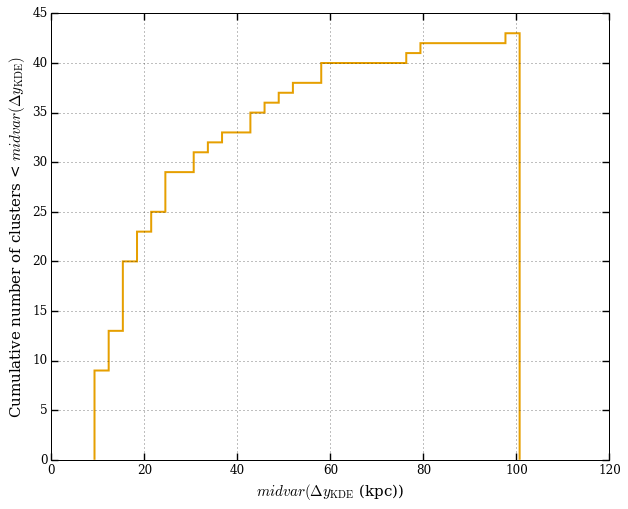

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
mega_clst_prop_df['KDE_midvar'].hist(
    cumulative=True, lw=2, bins=30, ax=ax,
    histtype='step')
ax.set_xlabel(r'$midvar(\Delta y_{\rm KDE}$ (kpc))')
ax.set_ylabel(r'Cumulative number of clusters < $midvar(\Delta y_{\rm KDE})$')

# summarize the projection statistics for each cluster and put them in the dataframe with individual cluster properties

# compute the correlation between different cluster properties

In [21]:
clst_props = list(mega_clst_prop_df.columns)
clst_props.remove('clstNo')

In [22]:
import itertools

get different combinations of pairs 

In [23]:
comb = itertools.combinations(clst_props, 2)

In [24]:
correlation_dict = {pair: scipy.stats.pearsonr(
                    mega_clst_prop_df[pair[0]], 
                    mega_clst_prop_df[pair[1]])
                    for pair in itertools.combinations(clst_props, 2)}

the first entry is correlation, the second is the p-value that the correlation arises by chance

In [25]:
corr_df = pd.DataFrame(correlation_dict).transpose()

In [26]:
corr_df.columns = ['Pearson correlation', 'p-value']

In [27]:
corr_df

Pearson correlation       p-value
Delta_y_KDE_max median_tot_peak_dens             0.767058  1.988306e-09
GroupMass       Delta_y_KDE_max                  0.139069  3.737884e-01
                KDE_midvar                       0.071087  6.505578e-01
                median_tot_peak_dens             0.280300  6.867122e-02
                relaxedness0                    -0.037634  8.106446e-01
                relaxedness1                     0.036462  8.164366e-01
Group_M_Crit200 Delta_y_KDE_max                 -0.137391  3.796384e-01
                GroupMass                        0.929939  2.036091e-19
                Group_M_Crit500                  0.965219  1.659433e-25
                KDE_midvar                      -0.174703  2.625043e-01
                median_tot_peak_dens             0.007729  9.607667e-01
                relaxedness0                    -0.302216  4.887310e-02
                relaxedness1                    -0.261904  8.977856e-02
Group_M_Crit500 Delta_y_KDE_max                 -0.181488  2.441284e-01
                GroupMass                        0.900278  2.124033e-16
                KDE_midvar                      -0.225950  1.451403e-01
                median_tot_peak_dens            -0.031567  8.407398e-01
                relaxedness0                    -0.328685  3.139678e-02
                relaxedness1                    -0.279438  6.956331e-02
KDE_midvar      Delta_y_KDE_max                  0.919110  3.491700e-18
                median_tot_peak_dens             0.692713  2.646104e-07
relaxedness0    Delta_y_KDE_max                  0.700911  1.660371e-07
                KDE_midvar                       0.750786  6.697016e-09
                median_tot_peak_dens             0.785755  4.341002e-10
                relaxedness1                     0.816224  2.553062e-11
relaxedness1    Delta_y_KDE_max                  0.806657  6.556092e-11
                KDE_midvar                       0.705086  1.301700e-07
                median_tot_peak_dens             0.854630  3.072435e-13
richness        Delta_y_KDE_max                  0.208190  1.803424e-01
                GroupMass                        0.982564  1.389266e-31
                Group_M_Crit200                  0.872864  2.359197e-14
                Group_M_Crit500                  0.858273  1.893489e-13
                KDE_midvar                       0.137263  3.800869e-01
                median_tot_peak_dens             0.328578  3.145496e-02
                relaxedness0                     0.024558  8.757850e-01
                relaxedness1                     0.097542  5.337685e-01

# plot the `total_peak_dens` per cluster per projection

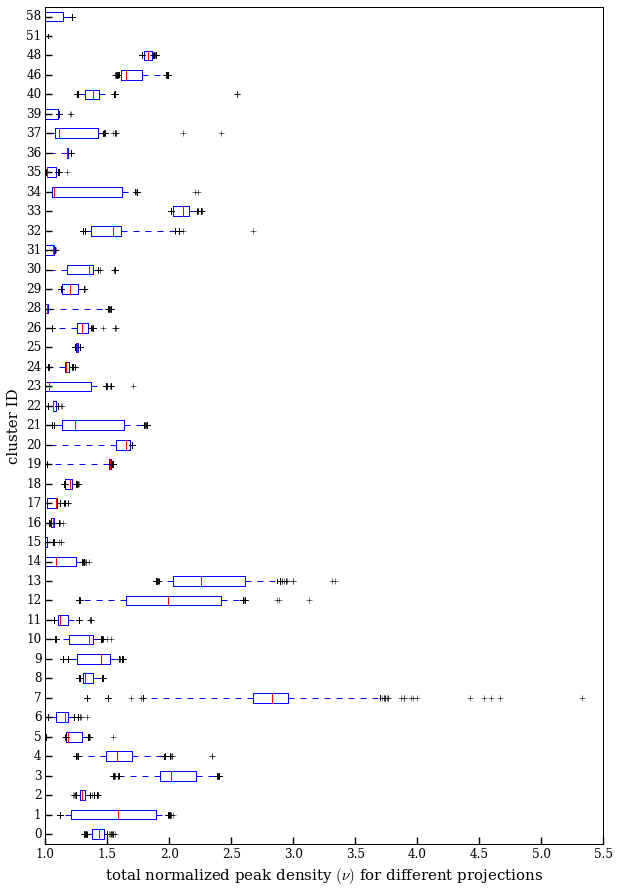

In [33]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111)
_ = plt.boxplot(clst_total_peak_dens_stat, vert=0, whis=[5, 95])

labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(labels)):
    labels[i] = rich_clst_nos[i]

ax.set_yticklabels(labels)
ax.tick_params(labeltop='off', labelright='off')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('cluster ID')
ax.set_xlabel(r'total normalized peak density $(\nu)$ for different projections')
plt.savefig('../../paper/figures/finalized/' + 
            'fig8_total_normalized_peak_density.pdf', bbox_inches='tight')

## we also visualize the distribution of the projected relaxedness

In [ ]:
plt.hist()

# provide the table of distributions in LaTeX form

In [463]:
mega_clst_prop_key_conversion = OrderedDict([
    (u'clstNo', "ID"), 
    (u'richness', "richness"),
    (u'Group_M_Crit200', r"M$_{\rm 200C} (10^{14} M_\odot)$"),
    (u'Group_M_Crit500', r"M$_{\rm 500C} (10^{14} M_\odot)$"),
    (u'GroupMass', r"M$_{\rm FoF} (10^{14} M_\odot)$ "),
    (u'relaxedness0', r"relaxedness$_0$"),
    (u'relaxedness1', r"relaxedness$_1$"),
    (u'Delta_y_KDE_max', r"max($\Delta y_{\rm KDE})$ (kpc)"),
    (u'KDE_midvar',  r"midvar($\Delta y_{\rm KDE})$ (kpc)"),
    (u'median_tot_peak_dens', r"med($\nu$)")
    ]
)

In [464]:
def str_format_2_dp(num):
    return "{0:0.2f}".format(num)

def str_format_int(num):
    return "{0:0.0f}".format(num)

def str_format_mass_in_10_to_14_solar_mass(num):
    return "{0:0.2f}".format(num / 1e4)

In [465]:
mega_clst_prop_df.columns = \
    [mega_clst_prop_key_conversion[k] 
     for k in mega_clst_prop_df.columns]

want to make sure the order of the string formatter is correct

In [466]:
str_formatters_dict = OrderedDict([
    ("ID",  str_format_int), 
    (u'richness',  str_format_int),
    (r"M$_{\rm 200C} (10^{14} M_\odot)$", str_format_mass_in_10_to_14_solar_mass,),
    (r"M$_{\rm 500C} (10^{14} M_\odot)$", str_format_mass_in_10_to_14_solar_mass,),
    (r"M$_{\rm FoF} (10^{14} M_\odot)$ ", str_format_mass_in_10_to_14_solar_mass,),
    (r"relaxedness$_0$", str_format_int,),
    (r"relaxedness$_1$", str_format_int,),
    (r"max($\Delta y_{\rm KDE})$ (kpc)", str_format_int,),
    (r"midvar($\Delta y_{\rm KDE})$ (kpc)", str_format_int,),
    (r"med($\nu$)", str_format_2_dp)]
)
str_formatters = [str_formatters_dict[k] 
                 for k in mega_clst_prop_df.columns]

In [467]:
with open("../../paper/clst_prop_table.tex", "w'") as f:
    f.write(mega_clst_prop_df.to_latex(
            formatters=str_formatters, escape=False, index=False))

In [468]:
!cat "../../paper/clst_prop_table.tex"

\begin{tabular}{rrrrrrrrrr}
\toprule
ID & richness & M$_{\rm 200C} (10^{14} M_\odot)$ & M$_{\rm 500C} (10^{14} M_\odot)$ & M$_{\rm FoF} (10^{14} M_\odot)$  & relaxedness$_0$ & relaxedness$_1$ & midvar($\Delta y_{\rm KDE})$ (kpc) & max($\Delta y_{\rm KDE})$ (kpc) & med($\nu$) \\
\midrule
 0 &      483 &                             1.64 &                             1.09 &                             3.23 &              29 &              33 &                                 31 &                              65 &       1.43 \\
 1 &      338 &                             1.57 &                             0.62 &                             2.68 &              20 &              16 &                                 25 &                              71 &       1.59 \\
 2 &      267 &                             1.53 &                             0.87 &                             2.12 &              17 &               3 &                                 18 &                              42 & 

# explore the statistics of the different properties of the clusters

In [288]:
mega_stat = mega_clst_prop_df.describe()

In [287]:
mega_stat

,count,mean,std,min,25%,50%,75%,max
clstNo,43,22.279070,14.645535,0.000000,10.500000,21.000000,32.500000,58.000000
richness,43,122.372093,94.769903,52.000000,62.500000,83.000000,153.000000,483.000000
Group_M_Crit200,43,4649.763169,4009.160862,847.697266,2081.353027,2933.823486,5418.822510,16354.563477
Group_M_Crit500,43,2880.406088,2300.692375,582.890747,1386.251282,1837.197632,3409.755615,10852.893555
GroupMass,43,8137.841570,6760.438671,2318.145264,3925.385498,5037.233887,10493.600586,32287.929688
relaxedness0,43,27.491925,14.896358,10.790944,17.563505,22.775710,32.822666,63.851303
relaxedness1,43,38.072795,53.205190,2.526460,7.872798,15.747442,46.771888,280.113265
Delta_y_KDE_max,43,76.686343,66.306782,22.395786,32.855034,51.961892,102.880873,378.925231
KDE_midvar,43,28.726426,21.506244,9.259785,13.542103,19.601170,37.375774,100.683657
biweight_tot_peak_dens,39,1.405646,0.400909,1.006067,1.141094,1.296950,1.552014,2.837843


In [292]:
massive_clst = mega_clst_prop_df[
    mega_clst_prop_df['GroupMass'] > 1e4]

In [496]:
mega_clst_prop_df.keys()

Index([u'ID', u'richness', u'M$_{\rm 200C} (10^{14} M_\odot)$', u'M$_{\rm 500C} (10^{14} M_\odot)$', u'M$_{\rm FoF} (10^{14} M_\odot)$ ', u'relaxedness$_0$', u'relaxedness$_1$', u'midvar($\Delta y_{\rm KDE})$ (kpc)', u'max($\Delta y_{\rm KDE})$ (kpc)', u'med($\nu$)'], dtype='object')

In [515]:
relaxed_mask = mega_clst_prop_df[
    mega_clst_prop_df['med($\\nu$)'] < 1.2]['ID']

In [521]:
mega_clst_prop_df.keys()

Index([u'ID', u'richness', u'M$_{\rm 200C} (10^{14} M_\odot)$', u'M$_{\rm 500C} (10^{14} M_\odot)$', u'M$_{\rm FoF} (10^{14} M_\odot)$ ', u'relaxedness$_0$', u'relaxedness$_1$', u'midvar($\Delta y_{\rm KDE})$ (kpc)', u'max($\Delta y_{\rm KDE})$ (kpc)', u'med($\nu$)'], dtype='object')

In [530]:
len(relaxed_mask) / 43.

0.4883720930232558

In [574]:
unrelaxed_mask = np.logical_and(mega_clst_prop_df['med($\\nu$)'] > 1.2,
                                mega_clst_prop_df['med($\\nu$)'] < 2.2)

In [535]:
mega_clst_prop_df.ix[unrelaxed_mask]['ID']

3      3
7      7
12    12
20    20
21    21
32    32
33    33
37    37
40    40
46    46
Name: ID, dtype: int64

In [528]:
mega_clst_prop_df.ix[relaxed_mask, [r'midvar($\Delta y_{\rm KDE})$ (kpc)']]

,midvar($\Delta y_{\rm KDE})$ (kpc)
5,15.968700
6,15.205974
11,36.499875
14,16.551256
15,11.387037
16,13.095609
17,27.148980
18,13.722116
22,9.565620
23,26.259667


# check if subsetting by $\nu$ significantly affects the distribution of $M_{FoF}$ 

In [545]:
FoF_key = r'M$_{\rm FoF} (10^{14} M_\odot)$ '

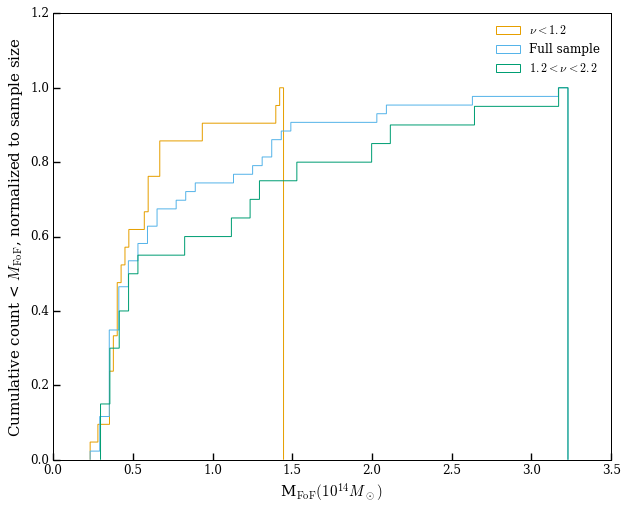

In [580]:
_ = plt.hist(np.array(mega_clst_prop_df.ix[relaxed_mask, [FoF_key]]) / 10000., 
             cumulative=True, histtype='step', 
             bins=50, label=r'$\nu < 1.2$', normed=True)
_ = plt.hist(mega_clst_prop_df[FoF_key] / 10000., 
             cumulative=True, histtype='step', bins=50, normed=True,
             label='Full sample')
_ = plt.hist(np.array(mega_clst_prop_df.ix[unrelaxed_mask, [FoF_key]]) / 10000., 
             cumulative=True, histtype='step', bins=50, normed=True,
            label=r'$ 1.2 < \nu < 2.2$'
            )
plt.ylabel(r"Cumulative count < $M_{\rm FoF}$, normalized to sample size")
plt.xlabel(FoF_key)
plt.legend(loc='best')
plt.tick_params(labeltop='off', labelright='off')
plt.axes().yaxis.set_ticks_position('left')
plt.axes().xaxis.set_ticks_position('bottom')
plt.savefig('../../paper/figures/finalized/Mass_abundance_relationship.pdf', bbox_inches='tight')